In [34]:
import csv
data = {}
with open('citations.csv', newline='') as csvfile:
    citations = csv.reader(csvfile)
    header = None
    for row in citations:
        citation = ""
        if header == None:
            header = row
        else:
            authors = row[0].split("; ")
            for author in authors:
                if len(author) >= 2:
                    if len(citation) > 0:
                        citation += ", "
                    array = author.split(", ")
                    if len(array) > 1:
                        citation += array[0]+", "
                        newarray = array[1].split(" ")
                        for item in newarray:
                            citation += item[0]+"."
            citation += ', "'+row[1]+'," '+row[2]+", "+row[3]+"("+row[4]+"), "+row[6]+"."
            if row[6] not in data:
                data[row[6]] = []
            data[row[6]].append(citation)
            keylist = []
            for year in data.keys():
                keylist.append(year)
            keylist.sort(reverse = True)
for year in keylist:
    for citation in data[year]:
        print(citation)
            


Nayfach, S., Roux, S., Seshadri, R., Udwary, D., Varghese, N., Schulz, F., Wu, D., Paez-Espino, D., Chen, I., Huntemann, M., "A genomic catalog of Earth’s microbiomes," Nature biotechnology, 39(4), 2021.
Seaver, S.M., Liu, F., Zhang, Q., Jeffryes, J., Faria, J.P., Edirisinghe, J.N., Mundy, M., Chia, N., Noor, E., Beber, M.E., "The ModelSEED Biochemistry Database for the integration of metabolic annotations and the reconstruction, comparison and analysis of metabolic models for plants, fungi and microbes," Nucleic acids research, 49(D1), 2021.
Rubinstein, R.L., Borton, M.A., Zhou, H., Shaffer, M., Hoyt, D.W., Stegen, J., Henry, C.S., Wrighton, K.C., Versteeg, R., "ORT: A workflow linking genome-scale metabolic models with reactive transport codes," bioRxiv, (), 2021.
Hanson, A.D., McCarty, D.R., Henry, C.S., Xian, X., Joshi, J., Patterson, J.A., García-García, J.D., Fleischmann, S.D., Tivendale, N.D., Millar, A.H., "The number of catalytic cycles in an enzyme’s lifetime and why it matte

In [2]:
# constraints
# solution
# visualize

In [3]:
# def constraints(modelInfo,mediaInfo,kinetic_coeff,abundances=None):
#     kbase_api = cobrakbase.KBaseAPI()
#     model = kbase_api.get_from_ws(modelInfo[0],modelInfo[1])
#     model.solver = 'optlang-cplex'

#     #Applying uptake limit to total carbon uptake by model
#     eup = ElementUptakePkg(model)
#     eup.build_package({"C":60})
#     #Applying constraints based on KBase media
#     media = kbase_api.get_from_ws(mediaInfo[0],mediaInfo[1])
#     kmp = KBaseMediaPkg(model)
#     kmp.build_package(media)
#     #Applying community model kinetic constraints
#     ckp = CommKineticPkg(model)
#     ckp.build_package(kinetic_coeff,abundances) # <- SPECIES ABUNDANCE BUG?

#     biomass_objective = model.problem.Objective(
#         1 * model.reactions.bio1.flux_expression,
#         direction='max')
#     model.objective = biomass_objective
#     return model

In [4]:
def communityFBA(modelInfo,mediaInfo,kinetic_coeff,abundances=None):
    kbase_api = cobrakbase.KBaseAPI()
    model = kbase_api.get_from_ws(modelInfo[0],modelInfo[1])
    model.solver = 'optlang-cplex'

    #Applying uptake limit to total carbon uptake by model
    eup = ElementUptakePkg(model)
    eup.build_package({"C":60})
    #Applying constraints based on KBase media
    media = kbase_api.get_from_ws(mediaInfo[0],mediaInfo[1])
    kmp = KBaseMediaPkg(model)
    kmp.build_package(media)
    #Applying community model kinetic constraints
    ckp = CommKineticPkg(model)
    ckp.build_package(kinetic_coeff,abundances)

    biomass_objective = model.problem.Objective(
        1 * model.reactions.bio1.flux_expression,
        direction='max')
    model.objective = biomass_objective

    # FBA
    sol=model.optimize()
    
    # pFBA
#     sol = cobra.flux_analysis.pfba(model)
    
    #print(model.summary())

    # Compute exchanges
    metabolite_uptake = {}
    speciesNum = []
    for rxn in model.reactions:
        # obtain species
        ind = rxn.id.rfind('_')
        if (rxn.id[ind + 1] == 'c' or rxn.id[ind + 1] == 'p') and rxn.id[ind + 2: ] != '0':
            species = rxn.id[ind + 2: ]
            speciesNum.append(species)

            for metabolite in rxn.metabolites:
                if metabolite.compartment == "e0":
                    rate = 0
                    flux = sol.fluxes[rxn.id]
                    if flux != 0:
                        rate += rxn.metabolites[metabolite]*flux
                    if rate != 0:
                        metabolite_uptake[(metabolite.id,species)] = rate

    speciesNum = np.unique(speciesNum)
    numOfSpecies = len(speciesNum)

    # Cross feeding
    external_metabolites = []
    for rxn in model.reactions:
        for metabolite in rxn.metabolites:
            if metabolite.compartment == "e0":
                external_metabolites.append(metabolite.id)

    cross_all = []
    for metabolite in external_metabolites:
        r_out = {x: r for (m, x), r in metabolite_uptake.items() if m == metabolite and r > 0}
        r_in = {x: -r for (m, x), r in metabolite_uptake.items() if m == metabolite and -r > 0}
        total_in = sum(r_in.values())
        total_out = sum(r_out.values())
        total = max(total_in, total_out)
        if total_in > total_out:
            r_out[None] = total_in - total_out
        if total_out > total_in:
            r_in[None] = total_out - total_in

        cross = [(o1, o2, metabolite, r1 * r2 / total) for o1, r1 in r_out.items() for o2, r2 in r_in.items()]
        cross_all.extend(cross) # [donor, receiver, compound, rate]

#     for i in cross_all:
#         print(i)

    production = [[0] * numOfSpecies for i in range(numOfSpecies)] #production[donorSpecies][receiverSpecies]
    consumption = [[0] * numOfSpecies for i in range(numOfSpecies)]

    for i in cross_all:
        if i[0] is not None and i[1] is not None:
            production[int(i[0])-1][int(i[1])-1] += i[3]
            consumption[int(i[1])-1][int(i[0])-1] += i[3]

    # for i in production:
    #     print(i)
    # print(' ')
    # for i in consumption:
    #     print(i)
    
    G=nx.Graph()
    for i in speciesNum:
        G.add_node(i)
    for k in combinations(speciesNum, 2):
        sp1 = int(k[0])-1
        sp2 = int(k[1])-1
        if production[sp1][sp2] > consumption[sp2][sp1]:
            interaction_flux = production[sp1][sp2]
        else:
            interaction_flux = consumption[sp2][sp1]
        G.add_edge(k[0],k[1],weight=interaction_flux)

    pos=nx.circular_layout(G)
    nx.draw_networkx(G,pos)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

/Users/chenry/opt/anaconda3/lib/python3.7/site-packages/cobra/core/metabolite.py:86 UserWarning: invalid character '*' found in formula '*'
/Users/chenry/opt/anaconda3/lib/python3.7/site-packages/cobra/core/metabolite.py:86 UserWarning: invalid character '*' found in formula 'C12H20O10*2'


1:bio2
2:bio4


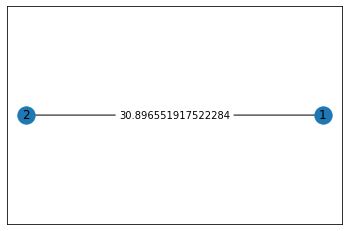

In [5]:
modelInfo_2 = ["CMM_iAH991V2_iML1515.kb",40576]
mediaInfo_2 = ["Btheta_Ecoli_minimal_media",40576]
communityFBA(modelInfo_2,mediaInfo_2,2100,{"1":0.5,"2":0.5})

1:bio2
2:bio4


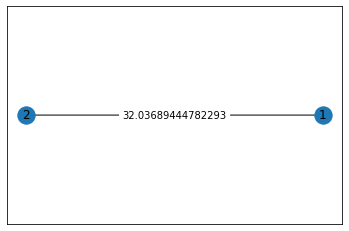

In [6]:
# changing the kinetic coefficient
communityFBA(modelInfo_2,mediaInfo_2,2300,{"1":0.5,"2":0.5})

1:bio2
2:bio4


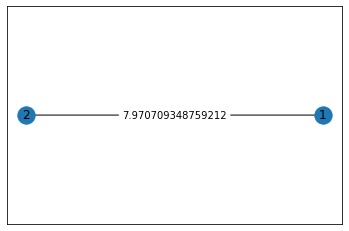

In [7]:
# changing the species abundances
communityFBA(modelInfo_2,mediaInfo_2,2100,{"1":0.1,"2":0.9})

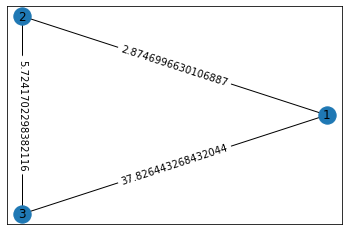

In [8]:
modelInfo_3 = ["electro.community.edited.v2",93204]
mediaInfo_3 = ["CO2_minimal",93204]
communityFBA(modelInfo_3,mediaInfo_3,2100)

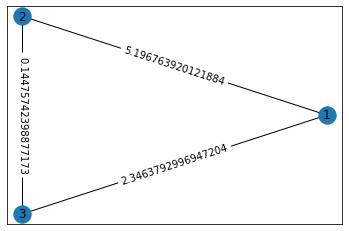

In [9]:
# changing the kinetic coefficient
communityFBA(modelInfo_3,mediaInfo_3,2300)

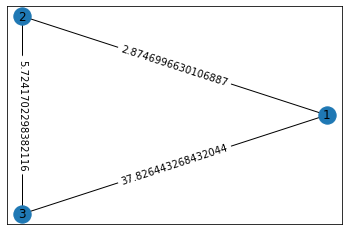

In [10]:
# changing the species abundances
communityFBA(modelInfo_3,mediaInfo_3,2100,abundances={"1":0.1,"2":0.1,"3":0.8})

In [11]:
# modelInfo_7 = ["Hot_Lake_seven.mdl.v2",94153]
# mediaInfo_7 = ["HotLakeMedia",94153]
# communityFBA(modelInfo_7,mediaInfo_7,2100)